Evidential Deep Learning to Quantify Classification Uncertainty
- aimed at detecting out-of-distribution queries and adversarial samples
- penalizes incorrect evidence on errors and out-of-distribution examples through loss function
    - evidence is a measure of the amount of support
collected from data in favor of a sample to be classified into a certain class
    - tries to shrink the total evidence (relu activation) to zero if the sample cannot be correctly classified 
    - uses Kullback–Leibler divergence (KL) loss to force the model to be uncertain especially when its prediction is incorrect through mean squared error, log likelihood, or digamma
- recognizes when the model is likely to fail

There are two axes of NN uncertainty that can be modeled: 
- (1) uncertainty in the data, called aleatoric uncertainty, and 
- (2) uncertainty in the prediction, called epistemic uncertainty.

This is a computationally efficient alternative to model ensembles, Bayesion NNs, and monte carlo dropout, which also gets at model uncertainty

In [21]:
import sys
sys.path.append('/home/vanessa/hulk/cocpit')
sys.path.append('/home/vanessa/hulk/ai2es')

import pandas as pd
from typing import List, Tuple
import os
from cocpit import config as config
from ai2es import evidential_utils as evidential

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


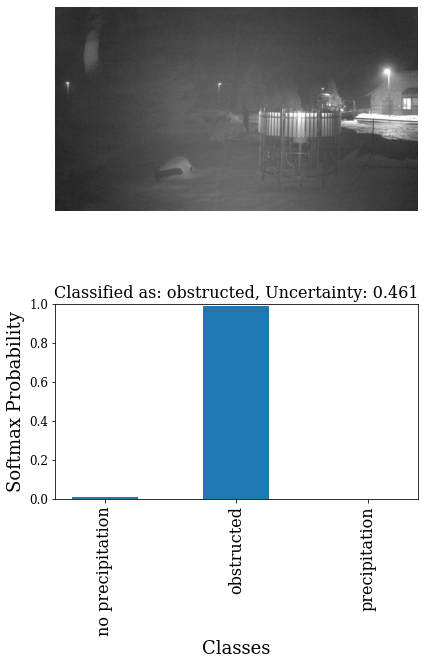

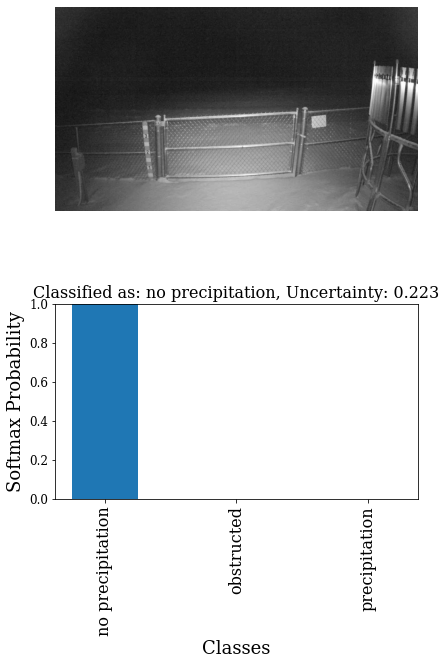

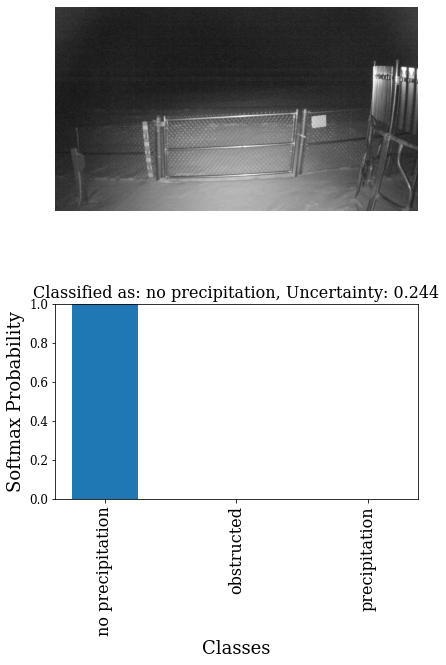

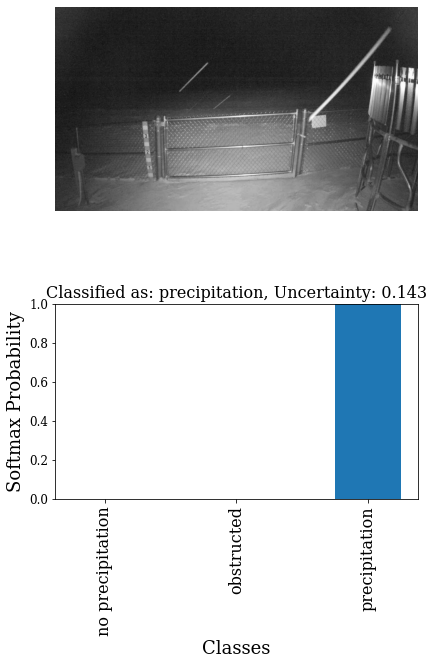

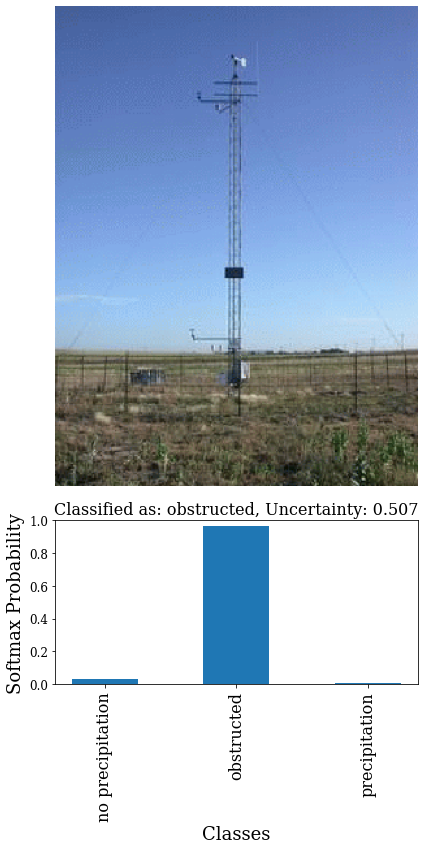

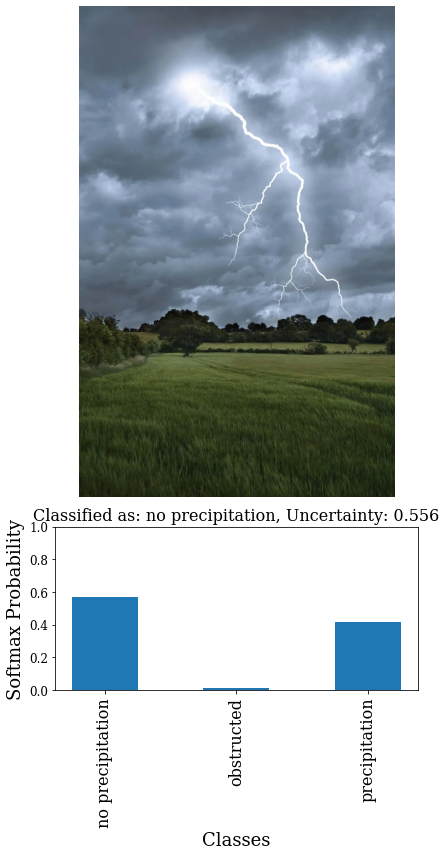

In [22]:
"""test uncertainty calculation on some hand chosen examples in and out of distribution norms"""
# sourcery skip: avoid-global-variables
import torch
model = torch.load(
    '/home/vanessa/hulk/ai2es/saved_models/v0.0.0/e[30]_bs[64]_k0_1model(s).pt')
img_paths = [f'{config.BASE_DIR}/codebook_dataset/combined_extra/obstructed/20170103T223007_NHUD.jpg',
             f'{config.BASE_DIR}/codebook_dataset/combined_extra/no_precip/20170101T080002_ANDE.jpg',
             f'{config.BASE_DIR}/codebook_dataset/combined_extra/no_precip/20170101T112501_ANDE.jpg',
             f'{config.BASE_DIR}/codebook_dataset/combined_extra/precip/20170101T030002_ANDE.jpg',
             f'{config.BASE_DIR}/notebooks/Oklahoma-Mesonet.png',
             f'{config.BASE_DIR}/notebooks/thunderstorm-and-lightning.png'
             ]
evidential.uncertainty_examples(model, img_paths)


In [23]:
"""get base filenames from Mesonet obs, not including the path to match with validation dataloader"""
df_obs = pd.read_parquet(
    "/home/vanessa/hulk/ai2es/matched_parquet/2017.parquet").reset_index()
# just get basedir of files since paths are different from validation dataloader
df_obs['filename'] = df_obs["path"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

In [24]:
"""Find distribution of evidential uncertainties and softmax probabilitie on validation dataloader"""
# sourcery skip: avoid-global-variables
import PIL
model = torch.load(
    '/home/vanessa/hulk/ai2es/saved_models/v1.0.0/e[30]_bs[64]_k0_1model(s).pt').to(config.DEVICE)
val_loader = torch.load('/home/vanessa/hulk/ai2es/saved_val_loaders/v1.0.0/e[30]_bs[64]_k0_1model(s).pt')

#correct = 0
preds, labels, probs, uncertainties, paths = [], [], [], [], []
with torch.no_grad():
    for ((img, label, path), _) in val_loader:
        img = PIL.Image.open(path)
        output = evidential.model_logit_output(model, img)
        pred, prob, uncertainty = evidential.calc_uncertainty(model, output)
        preds.append(pred.item())
        labels.append(label)
        probs.append(prob.cpu().numpy())
        uncertainties.append(uncertainty.item())
        paths.append(path)
        precip = df_obs['precip_accum_1min [mm]'][df_obs['filename'] == os.path.splitext(os.path.basename(path))[0]]
        #correct += (pred[0] == label).float().sum()
        #total = i
        #if uncertainty > 0.4:  # and prob[pred[0]] > 0.6:
        #    evidential.plot_uncertainty(img, pred, prob, uncertainty, precip)


KeyboardInterrupt: 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


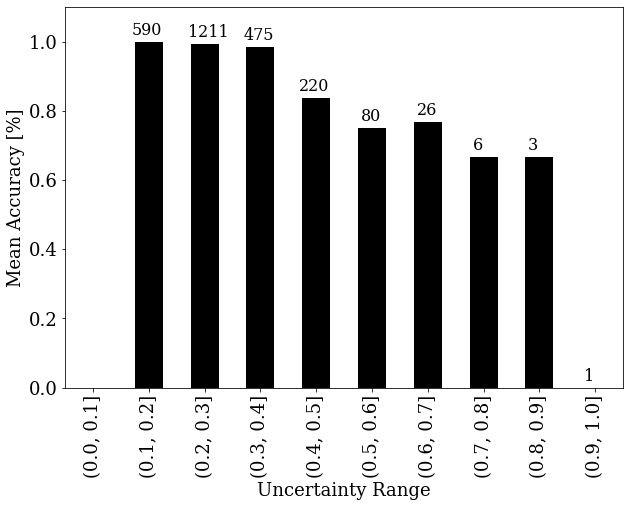

In [25]:
""" group by uncertainty """
# sourcery skip: avoid-global-variables
import numpy as np
df = pd.DataFrame(list(zip(preds, labels, probs, uncertainties, paths)), columns=[
                  'preds', 'labels', 'probs', 'uncertainties', 'paths'])
bins = np.linspace(0.0, 1.0, 11)
df['binned'] = pd.cut(df['uncertainties'], bins)
grouped_df = df.groupby('binned').apply(grouped_acc_df)
evidential.uncertainty_acc_hist(grouped_df)
